In [1]:
from sklearn.metrics import root_mean_squared_error

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [3]:
d = 2
sup = 1

n = 10_000
n_test = 100

# $\nu_{1} = \nu_{2} = 1/2$

In [4]:
nu_1 = 1/2
nu_2 = 1/2

## $\theta_{1} = 2$, $\theta_{2} = 2.5$

In [5]:
theta_1 = 2
theta_2 = 2.5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [7]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [9]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[0.02618922, 0.05659818, 0.0551047 , 0.05606095, 0.02023766,
        0.00047341, 0.13041014, 0.02188248, 0.0004856 ],
       [0.04037805, 0.05214101, 0.05299427, 0.06729874, 0.0277294 ,
        0.00126305, 0.1163604 , 0.02734377, 0.00131531],
       [0.03114653, 0.04698559, 0.05020732, 0.05366056, 0.02912544,
        0.00079816, 0.1095209 , 0.03329853, 0.00086039],
       [0.02785205, 0.05475003, 0.0690571 , 0.07315678, 0.02208352,
        0.00127423, 0.10662216, 0.02453165, 0.00148539],
       [0.02432367, 0.05244851, 0.05814574, 0.0547541 , 0.0179003 ,
        0.0005047 , 0.10617311, 0.01930421, 0.00053694],
       [0.02519241, 0.04185643, 0.04380671, 0.04979382, 0.0220421 ,
        0.00084331, 0.10158494, 0.02363911, 0.00078146],
       [0.03410668, 0.05732091, 0.06860533, 0.07070224, 0.02584996,
        0.00040594, 0.09677523, 0.02425787, 0.00049172],
       [0.03307061, 0.05653778, 0.0547597 , 0.05449517, 0.02015631,
        0.00059936, 0.09654416, 0.02443623, 0.00063192],


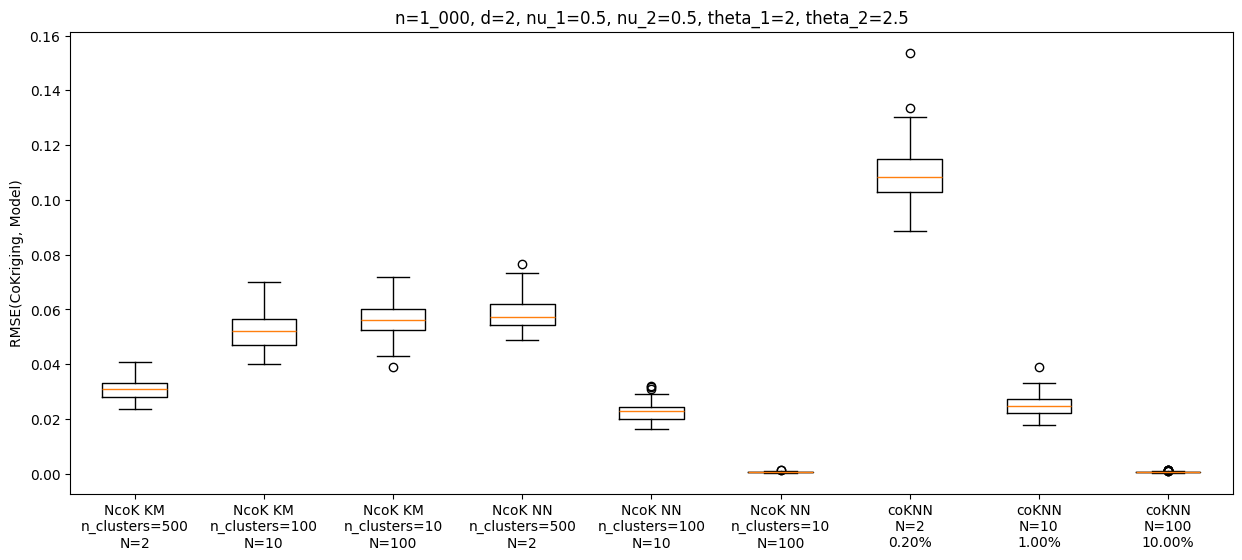

In [10]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [11]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.16637464, 0.17656011, 0.17682601, 0.17550489, 0.1673349 ,
        0.16696061, 0.20228476, 0.16824269, 0.16697316],
       [0.1735639 , 0.1835319 , 0.17794613, 0.17613902, 0.1756544 ,
        0.17590598, 0.20406149, 0.17656504, 0.17593364],
       [0.18477042, 0.19182235, 0.17874616, 0.18850734, 0.17531418,
        0.18160782, 0.18121016, 0.17509233, 0.18163614],
       [0.17879178, 0.17292564, 0.1744198 , 0.18220302, 0.17905335,
        0.17974998, 0.19189507, 0.1785509 , 0.17977435],
       [0.22548183, 0.2481959 , 0.23760961, 0.237882  , 0.22121193,
        0.22211858, 0.25545619, 0.22242423, 0.22211719],
       [0.15750048, 0.16245537, 0.164044  , 0.16506849, 0.16109485,
        0.15563702, 0.19303209, 0.16210815, 0.15563039],
       [0.16785806, 0.1785637 , 0.18666628, 0.18461606, 0.1668285 ,
        0.16396425, 0.19733955, 0.16725853, 0.16399802],
       [0.19833427, 0.21171348, 0.20440212, 0.20350083, 0.1976699 ,
        0.1955544 , 0.21217722, 0.19944348, 0.19554417],


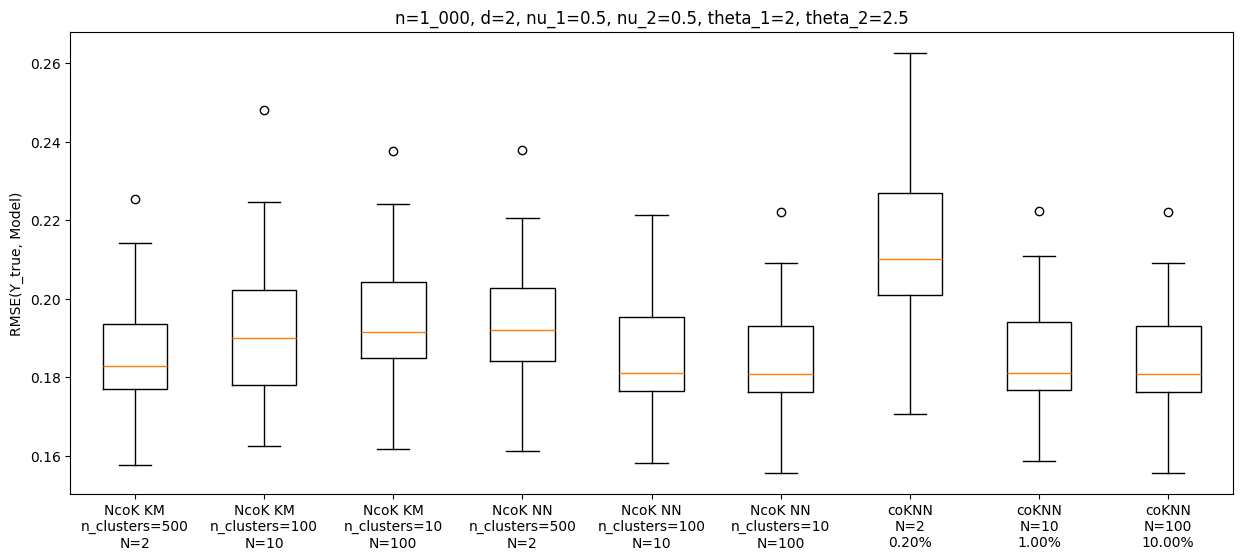

In [12]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [13]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.72390389e+01, 3.01644826e+00, 3.73417711e+00, 1.57994660e+03,
        7.35168672e+01, 9.38518214e+00, 4.50909138e-02, 1.00668430e-01,
        1.60189915e+00],
       [2.12032588e+01, 3.06660867e+00, 3.85066581e+00, 1.57043495e+03,
        7.23669610e+01, 9.46682286e+00, 3.28862667e-02, 4.88076210e-02,
        4.19646025e-01],
       [2.12002158e+01, 3.01722884e+00, 3.81028843e+00, 1.57735608e+03,
        7.33040309e+01, 9.55011797e+00, 2.82218456e-02, 4.74658012e-02,
        4.35238361e-01],
       [2.12277625e+01, 3.11611795e+00, 3.83809161e+00, 1.55435648e+03,
        7.41002455e+01, 9.64529777e+00, 3.48911285e-02, 4.61239815e-02,
        4.41367149e-01],
       [2.12158654e+01, 3.06822085e+00, 3.73311090e+00, 1.55493938e+03,
        7.26975815e+01, 9.44907379e+00, 2.77585983e-02, 4.53233719e-02,
        3.90044451e-01],
       [2.12665422e+01, 3.09984946e+00, 3.89954877e+00, 1.56858958e+03,
        7.28340092e+01, 9.53347898e+00, 2.80103683e-02, 4.96232510e-02,
        4.3

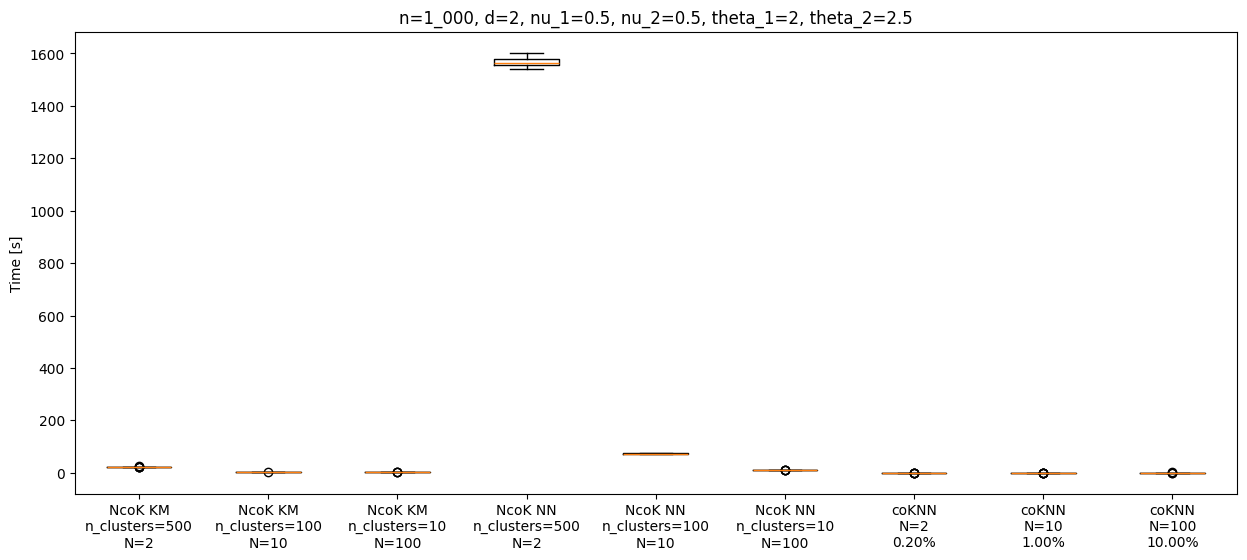

In [14]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Análisis $N$

In [ ]:
ns_clusters = [
    # 10, # 1000
    20, # 500
    50, # 200
    100,# 100
    200,# 50
]

rmses_NcoK_KM = []
rmses_NcoK_KM_true = []
times_NcoK_KM = []

num_replications = 50

for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for n_clusters in ns_clusters:
    # NcoK KM
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux.append(end_time-start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux)
    rmses_NcoK_KM_true.append(rmse_true_aux)
    times_NcoK_KM.append(time_aux)
    
    print(f'{_} listo :)')

In [41]:
np.array(rmses_NcoK_KM)

array([[0.02780539, 0.03197908, 0.03003273, 0.03278036],
       [0.03100892, 0.03420625, 0.03275433, 0.0320042 ],
       [0.04042706, 0.03728318, 0.03489779, 0.03168147],
       [0.02701565, 0.03068605, 0.0273255 , 0.02799084],
       [0.03563569, 0.03414156, 0.03632081, 0.0349028 ],
       [0.03179903, 0.04241599, 0.03715144, 0.03161982],
       [0.03566256, 0.02830637, 0.0328954 , 0.03074116],
       [0.03210096, 0.03473951, 0.02781628, 0.03019316],
       [0.03409888, 0.0310264 , 0.03356084, 0.03471159],
       [0.03625419, 0.03832952, 0.03507107, 0.03242259],
       [0.0248866 , 0.02484099, 0.02874681, 0.02992755],
       [0.03761191, 0.03539856, 0.03660675, 0.04005765],
       [0.03117196, 0.03258021, 0.03430895, 0.03243976],
       [0.02450933, 0.02891975, 0.0302962 , 0.02676116],
       [0.03324695, 0.03593897, 0.03159958, 0.03713086],
       [0.03418941, 0.03367404, 0.03187918, 0.03178441],
       [0.03442798, 0.03862956, 0.03666526, 0.03394318],
       [0.03633673, 0.03313391,

In [42]:
np.array(rmses_NcoK_KM_true)

array([[0.0929574 , 0.09419439, 0.09531165, 0.09483043],
       [0.1097854 , 0.11452995, 0.11046517, 0.10917973],
       [0.10631953, 0.10931904, 0.1064542 , 0.10722434],
       [0.10151694, 0.10462197, 0.10159544, 0.10148755],
       [0.10915609, 0.10690694, 0.11063588, 0.11067424],
       [0.11127389, 0.12076185, 0.11425842, 0.11737537],
       [0.10938165, 0.10910189, 0.10894333, 0.1095698 ],
       [0.09716978, 0.09672334, 0.09615593, 0.09850101],
       [0.0988653 , 0.10195001, 0.10008235, 0.09982313],
       [0.10796112, 0.11065594, 0.10977039, 0.10255176],
       [0.09679541, 0.09674743, 0.09808805, 0.09464589],
       [0.10339989, 0.10116066, 0.09942002, 0.0990963 ],
       [0.12299084, 0.11915305, 0.11963877, 0.11930543],
       [0.10623733, 0.10782107, 0.10739064, 0.10331291],
       [0.08440197, 0.0927448 , 0.08540812, 0.09051022],
       [0.10531623, 0.1047865 , 0.10339918, 0.10571489],
       [0.10488403, 0.10799145, 0.10396091, 0.10875709],
       [0.09148637, 0.09413787,

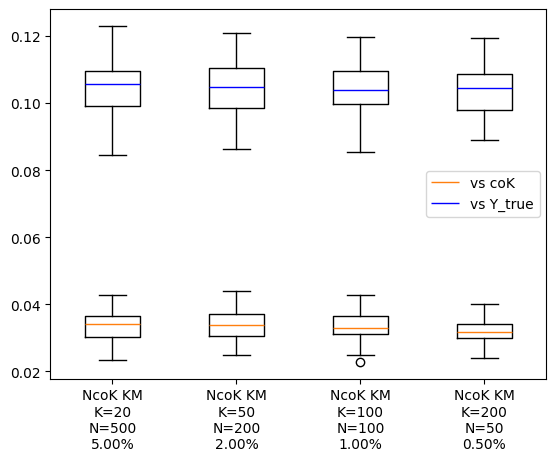

In [ ]:
plt.boxplot(np.array(rmses_NcoK_KM), label='vs coK')
plt.boxplot(np.array(rmses_NcoK_KM_true), medianprops={'c':'b'}, label='vs Y_true')
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters])
plt.legend();

In [43]:
np.array(times_NcoK_KM)

array([[103.30221081,  95.35122061, 108.38309789, 131.07361293],
       [ 89.96625042,  93.78582263, 105.48446012, 131.38435578],
       [ 90.63554215,  94.40216565, 106.49464822, 135.85510397],
       [ 92.20620346,  97.26936865, 120.75961852, 134.77352595],
       [ 92.98901844,  97.07349086, 107.44039083, 132.25157142],
       [ 91.01576543, 101.8486383 , 108.95752311, 135.97547197],
       [ 92.38483334,  97.06864238, 107.17993188, 132.2664299 ],
       [ 96.41851068,  96.58406878, 107.94194341, 135.88687348],
       [ 92.85289478,  99.2921102 , 111.22932696, 136.77201605],
       [ 92.48912525,  96.53731513, 108.75812483, 132.65421557],
       [ 92.08914614,  96.75930572, 108.42110157, 138.18343234],
       [ 90.99925041,  96.64132237, 107.2477479 , 133.31160331],
       [ 90.38700795,  96.11296105, 106.72821999, 138.33872557],
       [ 92.53454947,  97.7325592 , 107.8228817 , 136.31609488],
       [ 92.03988409,  96.73206973, 110.30114365, 132.22369289],
       [ 93.93613529,  96

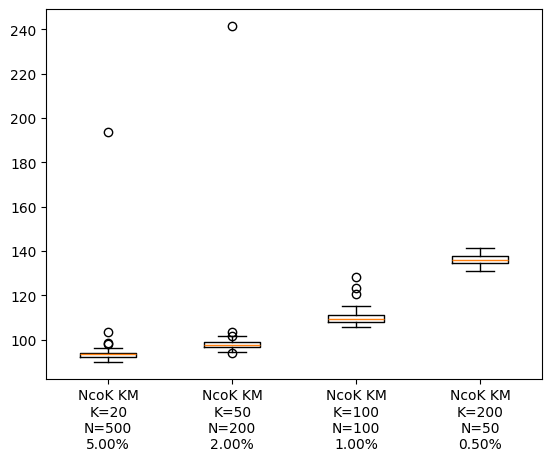

In [ ]:
plt.boxplot(np.array(times_NcoK_KM))
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters]);

## $\theta_{1} = 4$, $\theta_{2} = 5$

In [5]:
theta_1 = 4
theta_2 = 5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [7]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')
# 1274m 48.3s

### Resultados RMSE vs CoK

In [9]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[0.03185998, 0.0620989 , 0.06175665, 0.08331144, 0.02981375,
        0.000732  , 0.1401896 , 0.03277806, 0.00074711],
       [0.03663946, 0.06351723, 0.07049324, 0.09165939, 0.02792917,
        0.00061588, 0.16503871, 0.03229247, 0.00074246],
       [0.03077911, 0.05437974, 0.08144265, 0.07670429, 0.03683485,
        0.00112324, 0.14727529, 0.0390771 , 0.00113348],
       [0.03493717, 0.0692907 , 0.07915847, 0.08185348, 0.03050282,
        0.00069022, 0.16528247, 0.03275916, 0.00068194],
       [0.04019245, 0.06146176, 0.06598318, 0.07727887, 0.02503792,
        0.00045264, 0.13292485, 0.03097026, 0.00049285],
       [0.03623677, 0.07653347, 0.08319657, 0.0909598 , 0.02453747,
        0.00062885, 0.13230656, 0.02680312, 0.00063369],
       [0.03773185, 0.0605779 , 0.07056233, 0.08131479, 0.02684087,
        0.00057707, 0.15017068, 0.03030181, 0.00061912],
       [0.04089816, 0.07084965, 0.07771308, 0.07559024, 0.02985929,
        0.00077354, 0.123691  , 0.03389654, 0.00080274],


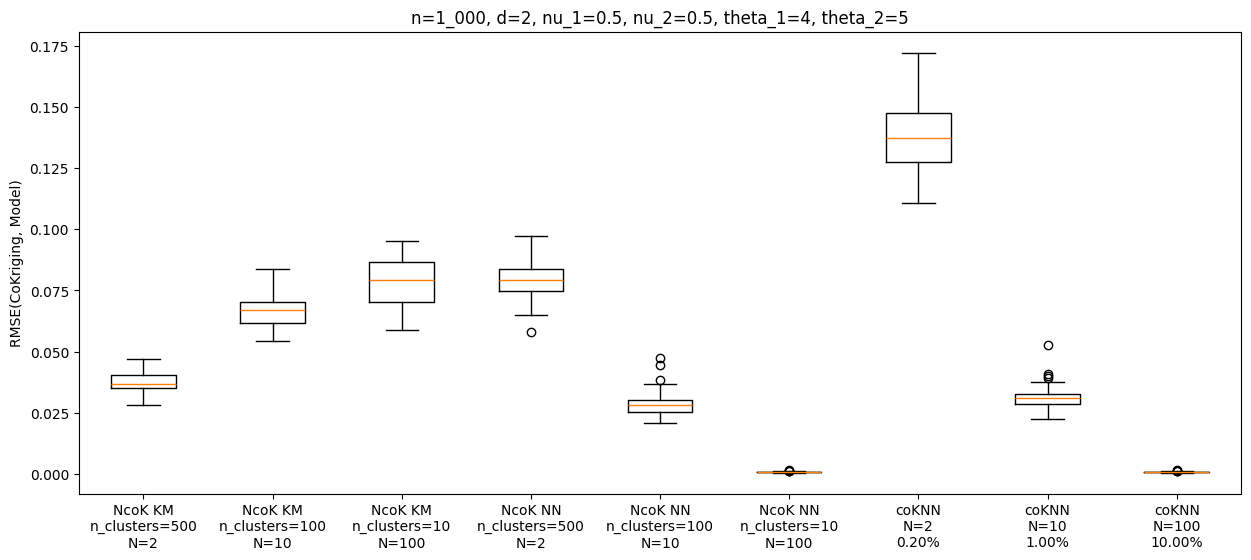

In [22]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [11]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.25314375, 0.24572582, 0.25605   , 0.26278014, 0.25303863,
        0.24380243, 0.29198853, 0.25196892, 0.2437774 ],
       [0.23806196, 0.24516075, 0.24510379, 0.24778977, 0.23772005,
        0.23473951, 0.28451153, 0.24155226, 0.23477438],
       [0.24659265, 0.23866643, 0.24678796, 0.25289401, 0.24334338,
        0.24487402, 0.28587409, 0.24165147, 0.24485341],
       [0.22810743, 0.24149449, 0.23797093, 0.24268888, 0.22876496,
        0.22253954, 0.28231315, 0.23113257, 0.22255858],
       [0.23324664, 0.23479746, 0.23837394, 0.24349804, 0.23036895,
        0.23507465, 0.26212133, 0.23232441, 0.2350684 ],
       [0.21078094, 0.21719188, 0.21541797, 0.21349313, 0.21070852,
        0.2098283 , 0.24720296, 0.21096906, 0.20980522],
       [0.27913118, 0.28516657, 0.29011211, 0.29833291, 0.28075133,
        0.27990309, 0.32524532, 0.28140099, 0.2798887 ],
       [0.27630355, 0.27635136, 0.29506632, 0.28834385, 0.27038795,
        0.26938524, 0.29722848, 0.26964119, 0.26940478],


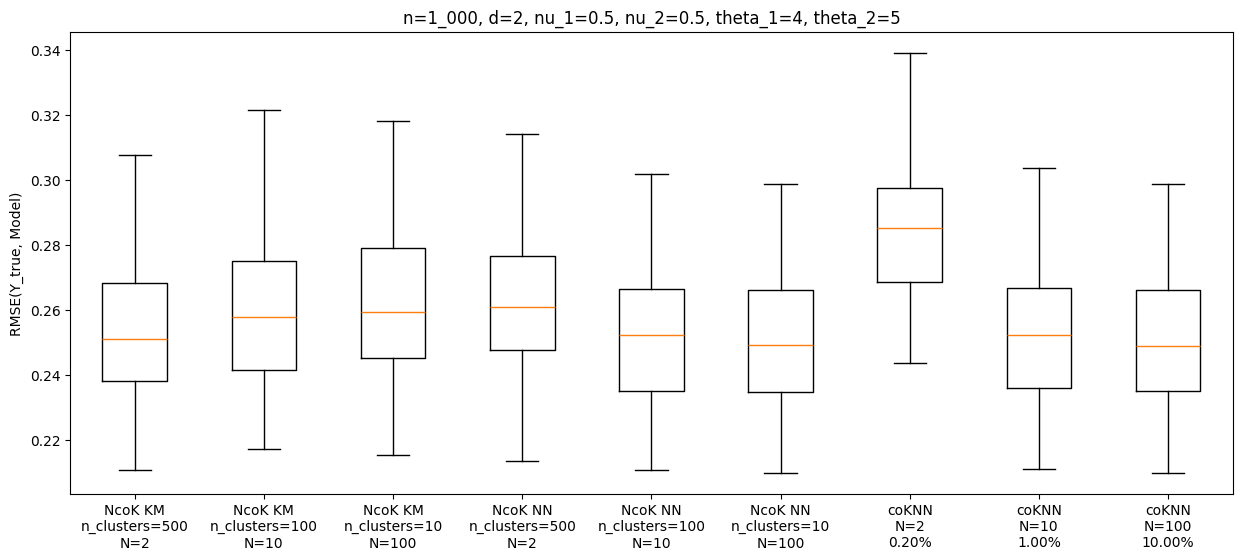

In [23]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [13]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.50187628e+01, 2.89991450e+00, 3.65001607e+00, 1.46365221e+03,
        6.74835649e+01, 9.26742387e+00, 3.78580093e-02, 8.63811970e-02,
        2.63550615e+00],
       [1.95001099e+01, 2.92347670e+00, 3.78328109e+00, 1.46579796e+03,
        6.78502269e+01, 9.41790080e+00, 3.35302353e-02, 5.52599430e-02,
        4.61072683e-01],
       [1.92003872e+01, 2.95212507e+00, 3.81640840e+00, 1.40577187e+03,
        6.59973602e+01, 9.81665707e+00, 1.63655281e-02, 6.01246357e-02,
        4.72677946e-01],
       [1.92005470e+01, 2.98811173e+00, 3.78322554e+00, 1.42423854e+03,
        6.81609182e+01, 9.43334889e+00, 3.35652828e-02, 3.28857899e-02,
        4.66695786e-01],
       [1.93138137e+01, 2.82248259e+00, 3.63176656e+00, 1.41774030e+03,
        6.68782563e+01, 9.31659293e+00, 3.28128338e-02, 4.54785824e-02,
        5.22253990e-01],
       [1.92193341e+01, 2.90001035e+00, 3.73821855e+00, 1.42865421e+03,
        6.66832714e+01, 9.44502187e+00, 2.67615318e-02, 3.43687534e-02,
        3.8

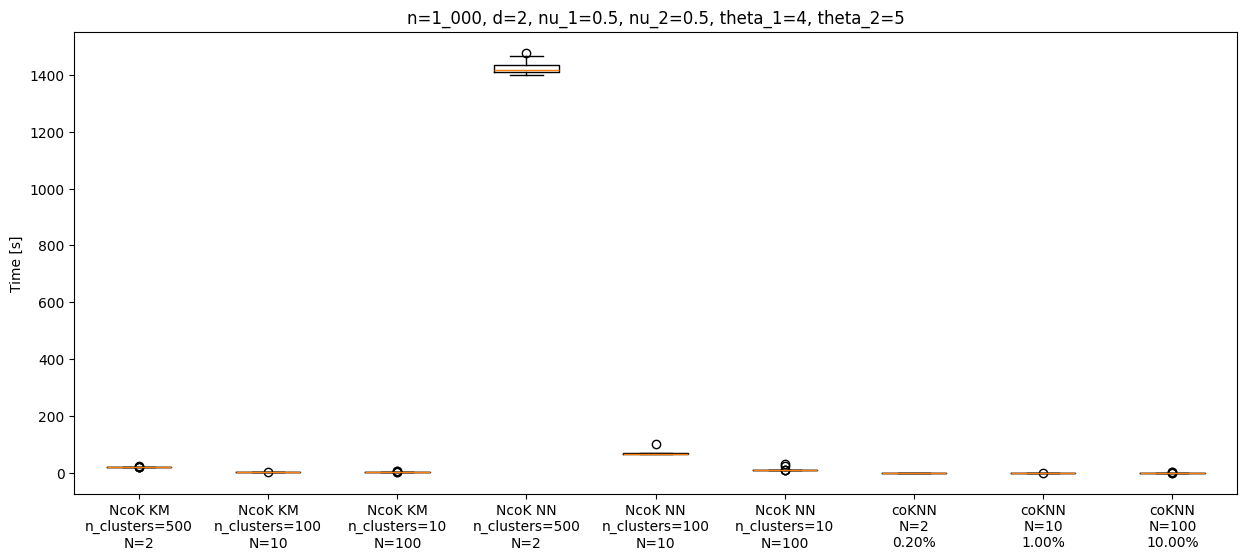

In [24]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Análisis $N$

In [ ]:
ns_clusters = [
    # 10, # 1000
    20, # 500
    50, # 200
    100,# 100
    200,# 50
]

rmses_NcoK_KM = []
rmses_NcoK_KM_true = []
times_NcoK_KM = []

num_replications = 50

for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for n_clusters in ns_clusters:
    # NcoK KM
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux.append(end_time-start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux)
    rmses_NcoK_KM_true.append(rmse_true_aux)
    times_NcoK_KM.append(time_aux)
    
    print(f'{_} listo :)')

In [8]:
np.array(rmses_NcoK_KM)

array([[0.04719825, 0.04452319, 0.04365364, 0.04429782],
       [0.05407321, 0.04827721, 0.05377764, 0.05431601],
       [0.04040154, 0.03954376, 0.03969957, 0.03864004],
       [0.03948329, 0.04071404, 0.04460984, 0.03918911],
       [0.05827565, 0.06168362, 0.05551505, 0.04706985],
       [0.04237118, 0.04285879, 0.04532623, 0.05143073],
       [0.0390073 , 0.04331143, 0.04297028, 0.0380224 ],
       [0.03922729, 0.04591016, 0.04677675, 0.04217999],
       [0.04655077, 0.04069943, 0.04381747, 0.03975623],
       [0.04605158, 0.04326784, 0.04307078, 0.04171307],
       [0.04707637, 0.04378212, 0.05364229, 0.04336288],
       [0.05615473, 0.05163259, 0.0560683 , 0.04829263],
       [0.0421372 , 0.04782279, 0.05144342, 0.04251557],
       [0.04782497, 0.04681515, 0.04314   , 0.04355952],
       [0.04711562, 0.04429511, 0.04844364, 0.04034387],
       [0.05116492, 0.05046109, 0.05034577, 0.0544755 ],
       [0.0501249 , 0.05016888, 0.05266415, 0.05293516],
       [0.04954141, 0.04779358,

In [9]:
np.array(rmses_NcoK_KM_true)

array([[0.1431242 , 0.15201263, 0.14818718, 0.14958477],
       [0.15098478, 0.14954336, 0.15025466, 0.1551851 ],
       [0.18379534, 0.17774459, 0.17871765, 0.17750259],
       [0.14659773, 0.14715238, 0.14704048, 0.1467477 ],
       [0.16445048, 0.16868444, 0.16572983, 0.16254966],
       [0.15285445, 0.15544807, 0.15752984, 0.15943244],
       [0.12518123, 0.12803507, 0.12559681, 0.1223064 ],
       [0.13086972, 0.1326678 , 0.13150804, 0.13377663],
       [0.15582551, 0.15056339, 0.15099139, 0.15122916],
       [0.15593148, 0.15447577, 0.15456751, 0.15543668],
       [0.15192603, 0.14843045, 0.15477082, 0.15225759],
       [0.15038463, 0.15131229, 0.15246611, 0.15447434],
       [0.14381248, 0.14300753, 0.14783944, 0.1442912 ],
       [0.13453302, 0.13750621, 0.14114912, 0.14135209],
       [0.16280103, 0.16270869, 0.16022921, 0.15657694],
       [0.15355006, 0.15823424, 0.15572729, 0.15388612],
       [0.14498222, 0.13841616, 0.14780794, 0.14544163],
       [0.16879723, 0.16918205,

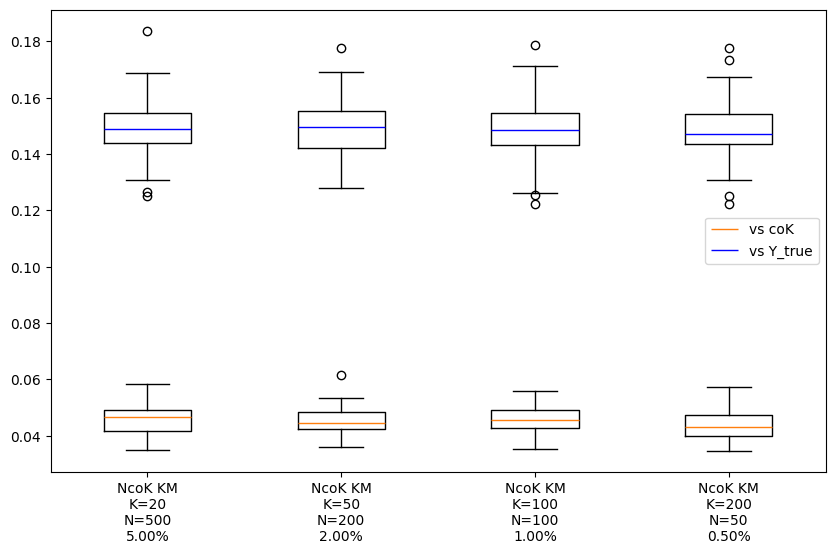

In [10]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(rmses_NcoK_KM), label='vs coK')
plt.boxplot(np.array(rmses_NcoK_KM_true), medianprops={'c':'b'}, label='vs Y_true')
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters])
plt.legend();

In [11]:
np.array(times_NcoK_KM)

array([[ 93.04668188,  90.98856735, 103.51282406, 130.95341849],
       [ 88.58792663,  89.92656636, 101.88255548, 127.52559018],
       [ 90.70246649, 104.61495566, 100.68558455, 127.2006588 ],
       [ 88.85569048,  93.17986536, 101.73288584, 127.26334357],
       [ 87.40918112,  89.80889726, 101.38531399, 130.06089854],
       [ 87.63076091,  91.35109758, 102.15734124, 130.88124967],
       [ 87.42521071,  89.58364749, 104.1504252 , 127.68961215],
       [ 88.76551557,  93.20734072, 102.15971899, 126.95815969],
       [ 88.50305796,  92.89881682, 106.21702051, 127.78089929],
       [ 87.06189322,  91.68899846, 102.07353663, 128.22523522],
       [ 86.95474291,  90.51800013, 104.43435955, 127.03957963],
       [ 88.53390193,  91.26296473, 100.33652425, 137.1838696 ],
       [ 85.92750049,  98.4754169 , 102.03300619, 127.55628252],
       [ 87.19905901,  90.94384432, 101.77584529, 128.62330914],
       [ 87.29994154,  93.94640851, 100.99044156, 126.50333667],
       [ 87.67993212,  92

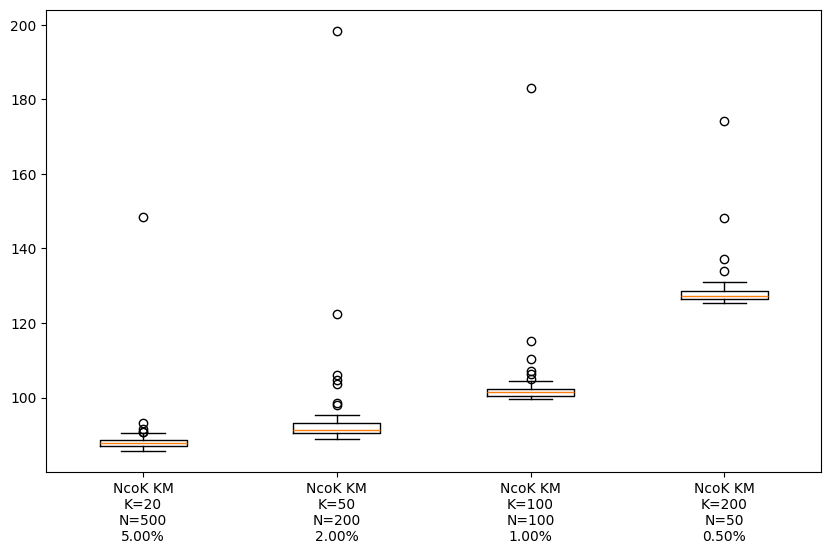

In [12]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(times_NcoK_KM))
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters]);

# $\theta_1 = 4$, $\theta_2 = 5$

In [4]:
theta_1 = 4
theta_2 = 5

## $\nu_{1} = 1/2, \nu_{2} = 5/2$

In [ ]:
nu_1 = 1/2
nu_2 = 5/2

In [ ]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5962847939999439

In [18]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [20]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[0.06420345, 0.05962285, 0.06199626, 0.0788834 , 0.05068887,
        0.00102407, 0.13869742, 0.05567003, 0.00101313],
       [0.05360974, 0.05998582, 0.0608185 , 0.07243951, 0.0439419 ,
        0.00108509, 0.13003309, 0.04436637, 0.00114005],
       [0.07049626, 0.06982345, 0.0666674 , 0.08372037, 0.04794527,
        0.00181643, 0.1791707 , 0.0495061 , 0.00182404],
       [0.06418686, 0.06713949, 0.0647777 , 0.08379302, 0.04715134,
        0.00103395, 0.17663785, 0.0528735 , 0.00108634],
       [0.05542708, 0.05755338, 0.05280193, 0.07758723, 0.05063042,
        0.00139412, 0.16365138, 0.05358576, 0.00130788],
       [0.05227021, 0.05836556, 0.05298261, 0.06959931, 0.04072744,
        0.00088945, 0.14962192, 0.0487255 , 0.0009293 ],
       [0.06089105, 0.05814366, 0.05453912, 0.07583949, 0.05333279,
        0.00084597, 0.16026   , 0.05768797, 0.00084526],
       [0.05728967, 0.0791088 , 0.06703751, 0.07751354, 0.05261264,
        0.00125915, 0.17099818, 0.06957053, 0.00123584],


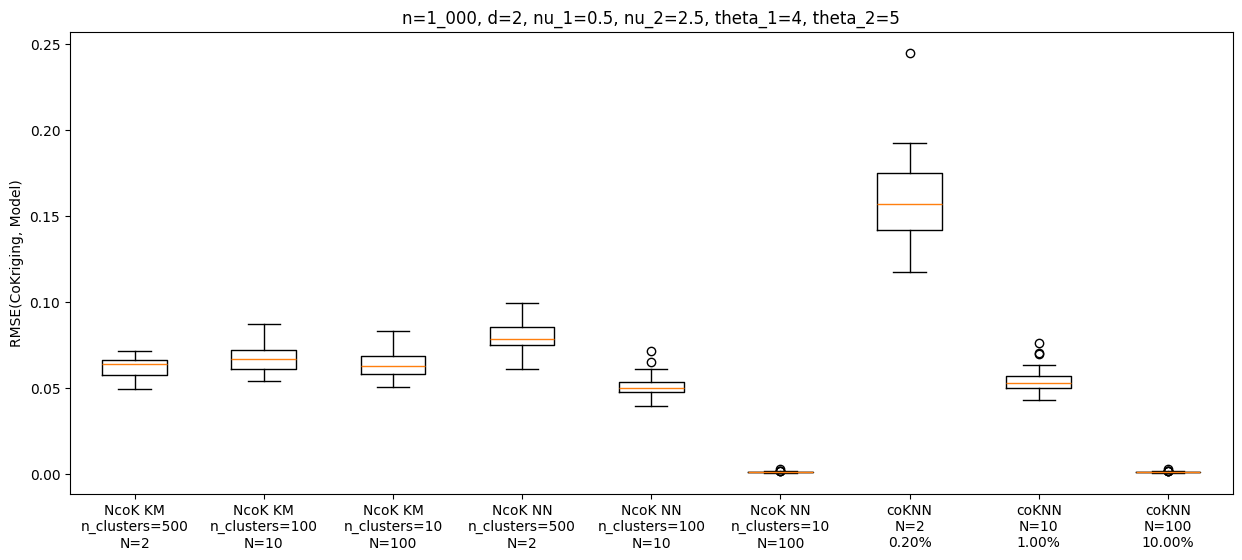

In [21]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [22]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.30033832, 0.29989846, 0.30275102, 0.29973746, 0.29891401,
        0.28645979, 0.32644398, 0.3010851 , 0.28645127],
       [0.28688717, 0.28776946, 0.29648799, 0.29394423, 0.28478952,
        0.2818698 , 0.3174333 , 0.28379298, 0.28185232],
       [0.27708574, 0.28197506, 0.28214744, 0.29689664, 0.28102761,
        0.26546378, 0.34745384, 0.28218567, 0.2654863 ],
       [0.26216026, 0.24915989, 0.26209858, 0.25391869, 0.25069432,
        0.24562217, 0.3182431 , 0.24925419, 0.24563944],
       [0.21522102, 0.22130228, 0.2242897 , 0.22526421, 0.21917405,
        0.21064801, 0.25090565, 0.21494669, 0.21060005],
       [0.24011619, 0.23889575, 0.24550004, 0.24273286, 0.24311115,
        0.24528562, 0.27943826, 0.24047611, 0.24529748],
       [0.25836439, 0.2648672 , 0.25814822, 0.26062233, 0.25573208,
        0.25065334, 0.31040032, 0.2576257 , 0.25064295],
       [0.24925314, 0.25387536, 0.2626732 , 0.26119977, 0.2492926 ,
        0.23696741, 0.31912008, 0.26032301, 0.23696798],


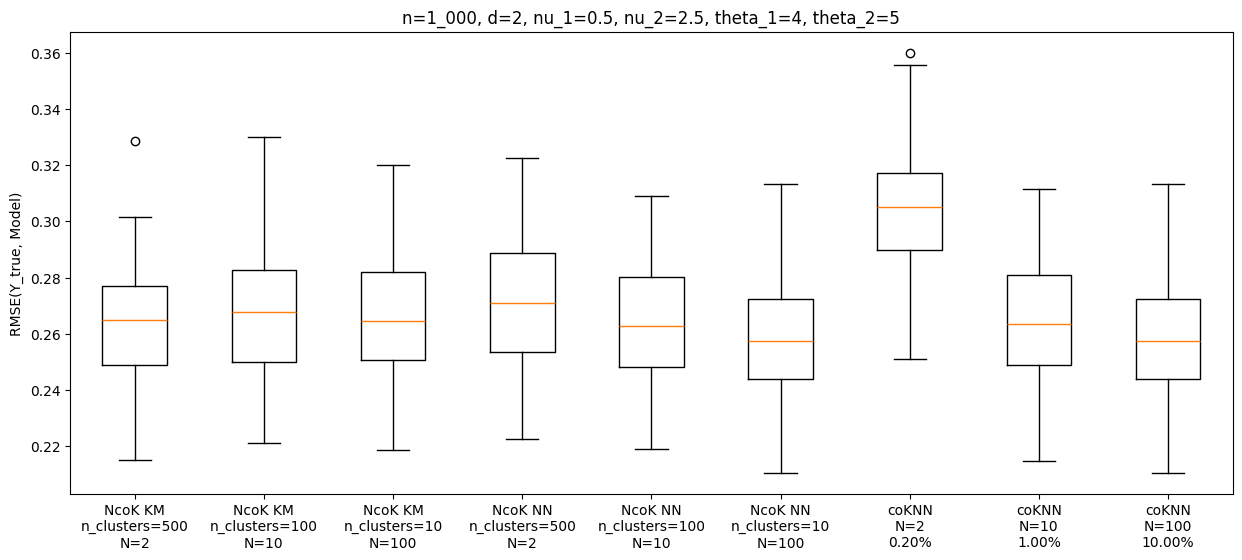

In [23]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [24]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.18047011e+01, 3.00970292e+00, 3.61670518e+00, 1.70472891e+03,
        7.61185441e+01, 9.44239211e+00, 1.70302391e-02, 6.66735172e-02,
        3.78025770e-01],
       [2.17020347e+01, 3.09990573e+00, 3.63789701e+00, 1.67703987e+03,
        7.86672187e+01, 9.50103855e+00, 3.35407257e-02, 4.96368408e-02,
        3.97350788e-01],
       [2.18089848e+01, 3.01662898e+00, 3.61715055e+00, 1.71217382e+03,
        7.81005921e+01, 9.46595550e+00, 3.23092937e-02, 5.03425598e-02,
        3.88182402e-01],
       [2.17007434e+01, 3.03358603e+00, 3.63234329e+00, 1.67427362e+03,
        7.63666272e+01, 9.41704035e+00, 2.96194553e-02, 5.35309315e-02,
        3.83395433e-01],
       [2.17673104e+01, 3.00910020e+00, 3.69966364e+00, 1.65149484e+03,
        7.61032875e+01, 9.41668749e+00, 3.33399773e-02, 6.65221214e-02,
        3.83299589e-01],
       [2.17498803e+01, 3.01703143e+00, 3.86674547e+00, 1.64758898e+03,
        7.70998368e+01, 9.48343325e+00, 4.12635803e-02, 4.20155525e-02,
        4.0

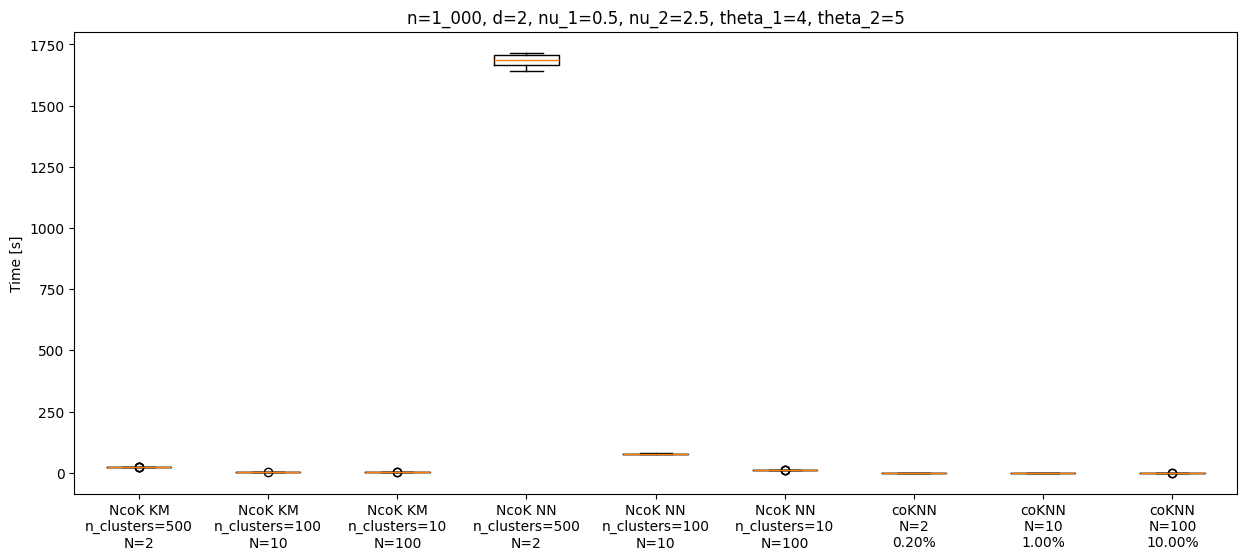

In [25]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Análisis $N$

In [ ]:
ns_clusters = [
    # 10, # 1000
    20, # 500
    50, # 200
    100,# 100
    200,# 50
]

rmses_NcoK_KM = []
rmses_NcoK_KM_true = []
times_NcoK_KM = []

num_replications = 50

for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for n_clusters in ns_clusters:
    # NcoK KM
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux.append(end_time-start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux)
    rmses_NcoK_KM_true.append(rmse_true_aux)
    times_NcoK_KM.append(time_aux)
    
    print(f'{_} listo :)')

In [15]:
np.array(rmses_NcoK_KM)

array([[0.05012472, 0.04485726, 0.04302783, 0.04377518],
       [0.04449079, 0.04412077, 0.0322786 , 0.0434419 ],
       [0.04348889, 0.0426543 , 0.04235475, 0.04015582],
       [0.04600359, 0.04602378, 0.0453498 , 0.04994817],
       [0.04320481, 0.04662451, 0.04253238, 0.0415202 ],
       [0.04658621, 0.04862462, 0.04493286, 0.04524079],
       [0.04511317, 0.04032552, 0.03973224, 0.04316966],
       [0.0501898 , 0.04431991, 0.04428413, 0.04816239],
       [0.03923157, 0.04536014, 0.03970395, 0.04059871],
       [0.05360205, 0.04494852, 0.04302748, 0.04006794],
       [0.04998875, 0.05118359, 0.04703675, 0.04935944],
       [0.04011705, 0.03909709, 0.04270056, 0.03859303],
       [0.04667153, 0.04189109, 0.04615562, 0.04411859],
       [0.05732568, 0.05888777, 0.05091679, 0.04492363],
       [0.04411185, 0.04773373, 0.04481917, 0.04076154],
       [0.04319338, 0.04271592, 0.0477701 , 0.04129631],
       [0.037489  , 0.03154723, 0.04215553, 0.04221154],
       [0.04983423, 0.05253616,

In [16]:
np.array(rmses_NcoK_KM_true)

array([[0.13846728, 0.13598118, 0.13257077, 0.13171401],
       [0.14204631, 0.14202883, 0.13809099, 0.13988741],
       [0.13375006, 0.13600326, 0.13761705, 0.14107987],
       [0.15128332, 0.15488274, 0.15259812, 0.15302286],
       [0.15279928, 0.15592681, 0.15624135, 0.15701766],
       [0.1581468 , 0.15678581, 0.15967531, 0.14852127],
       [0.14756267, 0.14508088, 0.14763966, 0.14899659],
       [0.15715948, 0.15880167, 0.15791092, 0.15741416],
       [0.14308306, 0.14378055, 0.13936454, 0.1444025 ],
       [0.15030614, 0.14573435, 0.14113873, 0.14239391],
       [0.17232374, 0.17846086, 0.17295886, 0.17358688],
       [0.14566637, 0.1464081 , 0.14296592, 0.14461149],
       [0.15679839, 0.16113131, 0.15207434, 0.15592012],
       [0.16462422, 0.16550077, 0.16344004, 0.1628899 ],
       [0.14726189, 0.14940774, 0.1490879 , 0.14896927],
       [0.13831233, 0.1383249 , 0.13822016, 0.13176446],
       [0.13425107, 0.13232572, 0.13577221, 0.13231334],
       [0.15875405, 0.15734477,

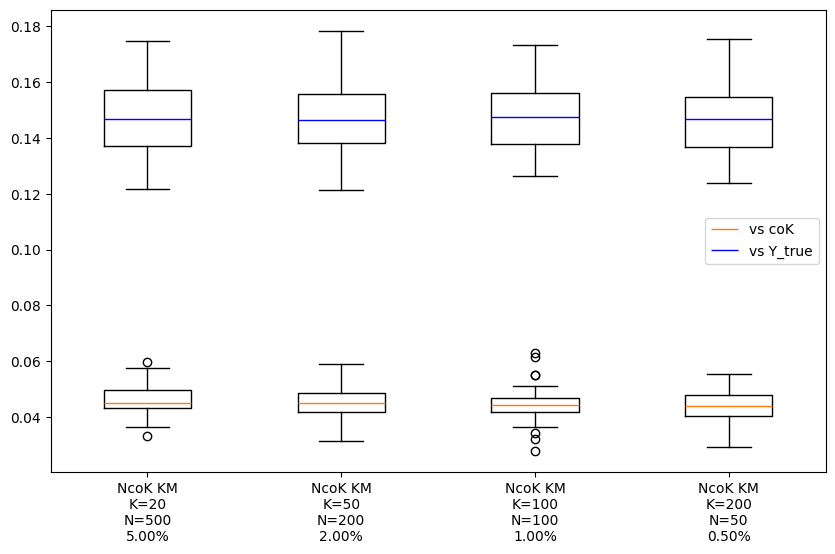

In [17]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(rmses_NcoK_KM), label='vs coK')
plt.boxplot(np.array(rmses_NcoK_KM_true), medianprops={'c':'b'}, label='vs Y_true')
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters])
plt.legend();

In [18]:
np.array(times_NcoK_KM)

array([[142.75568509, 189.12094688, 181.88236547, 172.11557269],
       [143.7695179 , 181.79377651, 190.94261909, 176.05875564],
       [147.43563986, 205.05051494, 187.54995489, 171.28982639],
       [166.18676972, 216.99413776, 221.20930171, 227.65237045],
       [165.19448948, 210.64850283, 222.39026618, 230.29865599],
       [159.63375044, 205.97190213, 218.93767333, 228.14677382],
       [161.87574267, 213.10269642, 223.75025606, 231.36784434],
       [163.41562986, 229.32656932, 222.35197163, 229.4642024 ],
       [164.61857176, 209.82592154, 223.26899362, 224.97474742],
       [173.05874276, 172.36279845, 148.90980077, 208.15382051],
       [116.46082163, 127.64223099, 150.07595921, 208.94214869],
       [119.65368867, 126.20796561, 149.98456192, 211.22611547],
       [111.99647498, 122.01906824, 150.2384131 , 201.51964784],
       [114.5861342 , 124.26754045, 144.24620605, 199.51710558],
       [112.41967416, 123.08942604, 154.30970955, 198.89294624],
       [113.80985737, 123

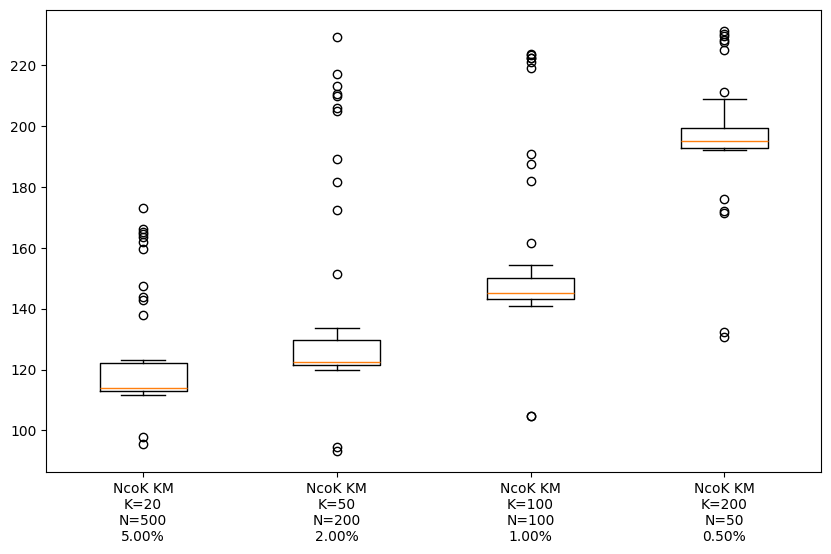

In [19]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(times_NcoK_KM))
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters]);

## $\nu_{1} = 5/2, \nu_{2} = 1/2$

In [20]:
nu_1 = 5/2
nu_2 = 1/2

In [21]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.5962847939999439

In [28]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [30]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[1.49335675e-03, 1.47185534e-03, 6.91699412e-04, 4.01182927e-03,
        6.55183205e-04, 9.90125436e-06, 3.77209564e-02, 7.30877139e-04,
        1.00699870e-05],
       [1.38622889e-03, 2.05927030e-03, 4.91551833e-04, 3.07695995e-03,
        6.69082845e-04, 9.90095928e-06, 2.58556342e-02, 7.69323651e-04,
        9.82406294e-06],
       [1.99039893e-03, 1.84477410e-03, 5.64841962e-04, 2.98800791e-03,
        6.97349753e-04, 9.17734647e-06, 3.51396392e-02, 6.50915168e-04,
        9.44767131e-06],
       [1.38589693e-03, 1.89307840e-03, 6.29452698e-04, 2.51380021e-03,
        1.17035870e-03, 8.93424851e-06, 3.44553482e-02, 1.20550825e-03,
        9.06211756e-06],
       [1.25050087e-03, 1.44918365e-03, 6.97116098e-04, 3.01999948e-03,
        6.33198049e-04, 1.07536709e-05, 2.93003706e-02, 7.68349766e-04,
        1.07824971e-05],
       [1.80793141e-03, 1.96793700e-03, 6.15282549e-04, 3.50620953e-03,
        7.89543285e-04, 1.73022225e-05, 3.85390481e-02, 1.06062936e-03,
        1.7

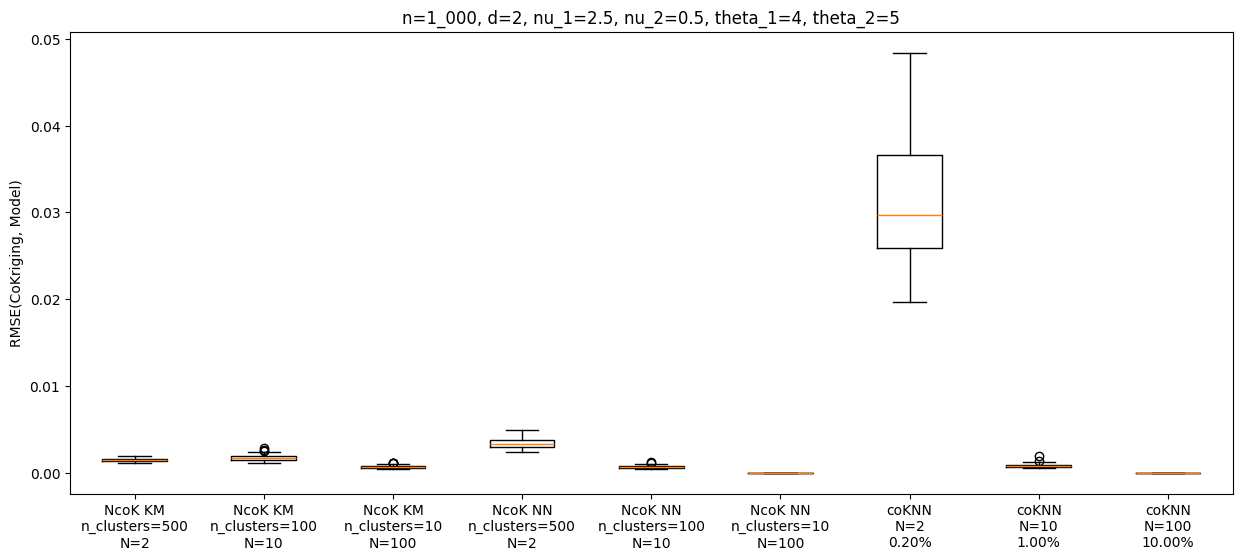

In [31]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [32]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.00160597, 0.00174206, 0.00103714, 0.00408008, 0.00112622,
        0.00068929, 0.03770205, 0.00115923, 0.00068937],
       [0.00165862, 0.00253076, 0.00104954, 0.00298361, 0.00111471,
        0.00087735, 0.02594861, 0.00120159, 0.0008773 ],
       [0.00231714, 0.00206716, 0.00074068, 0.00302229, 0.00110558,
        0.00062739, 0.03519365, 0.00100004, 0.00062738],
       [0.00149865, 0.00214581, 0.00076494, 0.00259902, 0.00128104,
        0.00058334, 0.03453621, 0.00131528, 0.00058332],
       [0.00162983, 0.00153506, 0.00102275, 0.0028428 , 0.00083411,
        0.00077871, 0.02926767, 0.00096979, 0.00077872],
       [0.00188818, 0.0023667 , 0.00148174, 0.00410992, 0.00149252,
        0.00130006, 0.0384963 , 0.00177195, 0.00129926],
       [0.00183959, 0.00186332, 0.00109775, 0.00370503, 0.00107496,
        0.00063286, 0.01961935, 0.00121612, 0.00063276],
       [0.00152896, 0.00158515, 0.00130673, 0.00330545, 0.0010227 ,
        0.0007206 , 0.03210255, 0.00112198, 0.00072051],


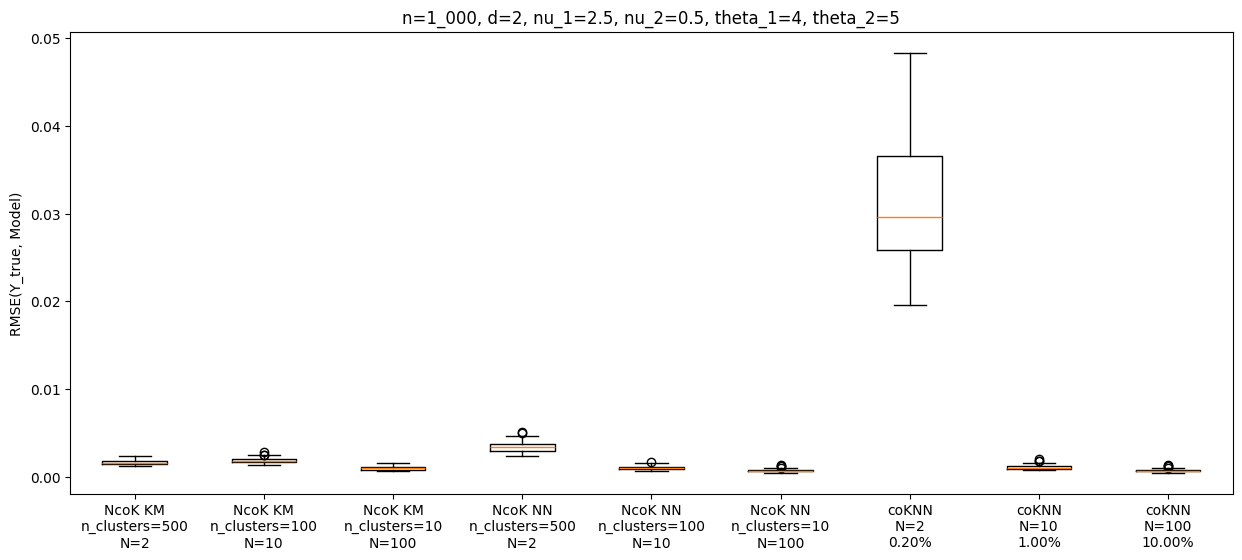

In [33]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [34]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.18633761e+01, 3.09989762e+00, 3.64341664e+00, 1.64373953e+03,
        7.57502754e+01, 9.39390182e+00, 3.15146446e-02, 5.18696308e-02,
        4.52737808e-01],
       [2.16670048e+01, 2.99988294e+00, 3.51742029e+00, 1.64297305e+03,
        7.63502762e+01, 9.34926915e+00, 1.66540146e-02, 6.53350353e-02,
        3.83329630e-01],
       [2.16335633e+01, 3.01811361e+00, 3.63338375e+00, 1.69787339e+03,
        7.81836081e+01, 9.41674232e+00, 4.01244164e-02, 5.94043732e-02,
        3.83218527e-01],
       [2.16194870e+01, 2.98354006e+00, 3.69979095e+00, 1.64100647e+03,
        7.75169268e+01, 9.42252851e+00, 1.80687904e-02, 6.64961338e-02,
        3.96320105e-01],
       [2.17003837e+01, 3.00317502e+00, 3.70097160e+00, 1.63912875e+03,
        7.56973853e+01, 9.37620521e+00, 1.62234306e-02, 6.65030479e-02,
        3.83356810e-01],
       [2.16216159e+01, 2.99994445e+00, 3.46780157e+00, 1.63818968e+03,
        7.83168926e+01, 9.65002275e+00, 3.23324203e-02, 5.08906841e-02,
        3.9

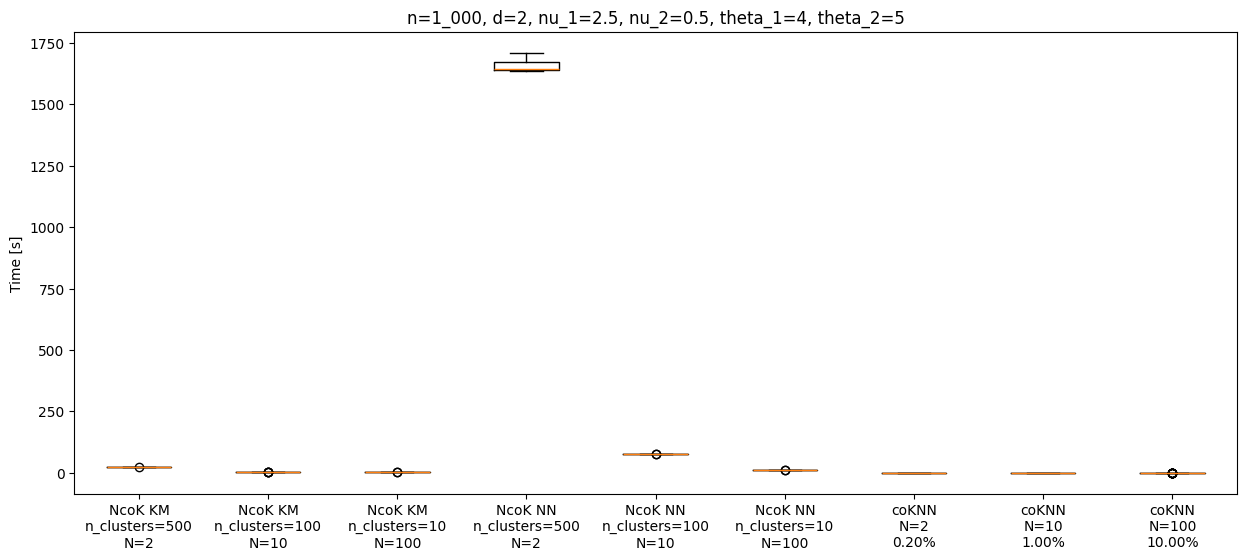

In [35]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Análisis $N$

In [ ]:
ns_clusters = [
    # 10, # 1000
    20, # 500
    50, # 200
    100,# 100
    200,# 50
]

rmses_NcoK_KM = []
rmses_NcoK_KM_true = []
times_NcoK_KM = []

num_replications = 50

for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for n_clusters in ns_clusters:
    # NcoK KM
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux.append(end_time-start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux)
    rmses_NcoK_KM_true.append(rmse_true_aux)
    times_NcoK_KM.append(time_aux)
    
    print(f'{_} listo :)')

In [23]:
np.array(rmses_NcoK_KM)

array([[1.93763111e-05, 4.01730818e-05, 3.27922637e-05, 1.06023572e-04],
       [3.73621152e-05, 2.64784865e-05, 5.47544045e-05, 5.80460496e-05],
       [2.29294632e-05, 3.03601924e-05, 6.57982662e-05, 4.67098077e-05],
       [2.55482861e-05, 1.93991869e-05, 4.42036705e-05, 3.88070047e-05],
       [2.63286820e-05, 4.56527960e-05, 5.29517931e-05, 1.36962472e-04],
       [3.40887194e-05, 3.77596781e-05, 4.94439055e-05, 7.74840467e-05],
       [2.67014399e-05, 2.45666210e-05, 2.92584943e-05, 5.73820910e-05],
       [2.19759514e-05, 3.19103347e-05, 4.57760664e-05, 7.19880967e-05],
       [2.07950405e-05, 6.07216491e-05, 3.64647316e-05, 5.17521570e-05],
       [2.88214615e-05, 2.65547191e-05, 4.56716441e-05, 6.18946752e-05],
       [2.00167079e-05, 4.66068861e-05, 3.45529265e-05, 5.02226295e-05],
       [2.56357499e-05, 5.22273911e-05, 5.89769928e-05, 1.03152188e-04],
       [3.24835020e-05, 4.41363931e-05, 3.29632183e-05, 7.77823467e-05],
       [3.13719272e-05, 2.97008005e-05, 3.19119746e

In [24]:
np.array(rmses_NcoK_KM_true)

array([[4.46166746e-05, 6.08488321e-05, 5.67484609e-05, 1.05860714e-04],
       [6.23422464e-05, 5.51298943e-05, 7.36112362e-05, 8.57046993e-05],
       [3.88361376e-05, 4.54023577e-05, 6.86471182e-05, 6.60505695e-05],
       [4.16508534e-05, 3.70836234e-05, 4.97982059e-05, 4.35024055e-05],
       [5.16024945e-05, 6.40860561e-05, 7.74309891e-05, 1.55219236e-04],
       [4.84871484e-05, 6.48988068e-05, 6.52810813e-05, 7.79252030e-05],
       [4.27200419e-05, 4.12154650e-05, 4.02015375e-05, 5.74136860e-05],
       [4.41799624e-05, 5.90769235e-05, 6.50051526e-05, 8.41880251e-05],
       [5.36009809e-05, 1.00599576e-04, 6.47461427e-05, 5.55538312e-05],
       [5.88204155e-05, 5.34562368e-05, 6.84200528e-05, 7.68398446e-05],
       [4.55838943e-05, 5.42381148e-05, 4.96600008e-05, 6.82325302e-05],
       [4.32946367e-05, 5.96385545e-05, 7.69051303e-05, 1.18776402e-04],
       [4.46069779e-05, 5.07793339e-05, 4.57407116e-05, 7.66865192e-05],
       [5.75941595e-05, 5.00885437e-05, 5.29002085e

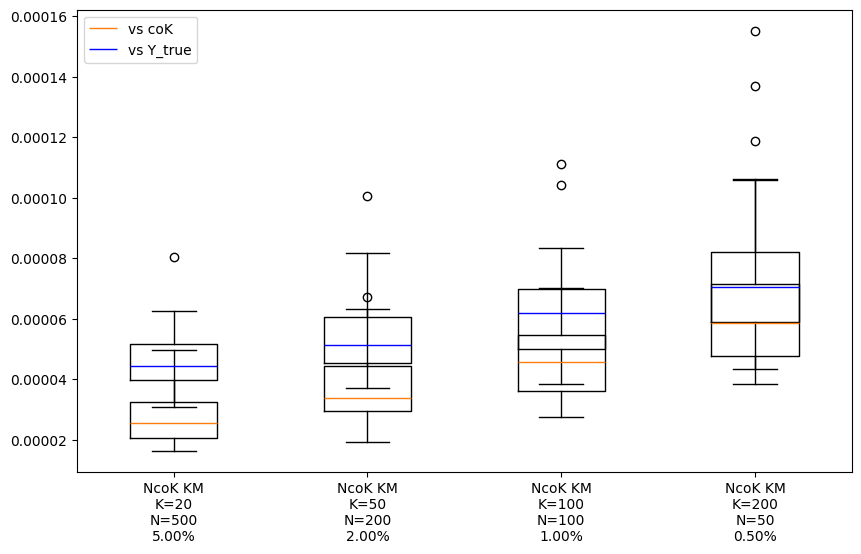

In [25]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(rmses_NcoK_KM), label='vs coK')
plt.boxplot(np.array(rmses_NcoK_KM_true), medianprops={'c':'b'}, label='vs Y_true')
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters])
plt.legend();

In [26]:
np.array(times_NcoK_KM)

array([[ 99.266186  ,  92.96521759, 103.59512091, 130.77956581],
       [ 95.52876329,  94.21067667, 104.13268757, 128.77135682],
       [ 93.86832952,  94.48697305, 103.18463469, 129.41935945],
       [ 95.80432034,  93.78273296, 103.20042348, 131.68688273],
       [123.3548286 ,  93.33382463, 102.93418956, 131.08367085],
       [ 95.62431669,  94.11119843, 103.16961145, 133.05554485],
       [ 96.03421712,  97.98094916, 104.58678794, 129.86837935],
       [ 95.40326428,  94.23279452, 108.16700244, 130.93469906],
       [ 95.00323987,  95.61769938, 111.76837468, 131.98411322],
       [ 95.45785737,  98.95165563, 327.98691082, 133.33396387],
       [ 95.82090878,  93.22725415, 102.13339877, 131.38518119],
       [ 96.36938429,  94.46800351, 104.36993623, 131.21773624],
       [ 96.40290141,  94.9514389 , 106.84911466, 131.9789331 ],
       [ 95.26428294,  94.52653408, 105.13354731, 132.35129428],
       [ 96.18836856, 110.59946632, 105.98472548, 132.71685529],
       [ 96.66957927,  94

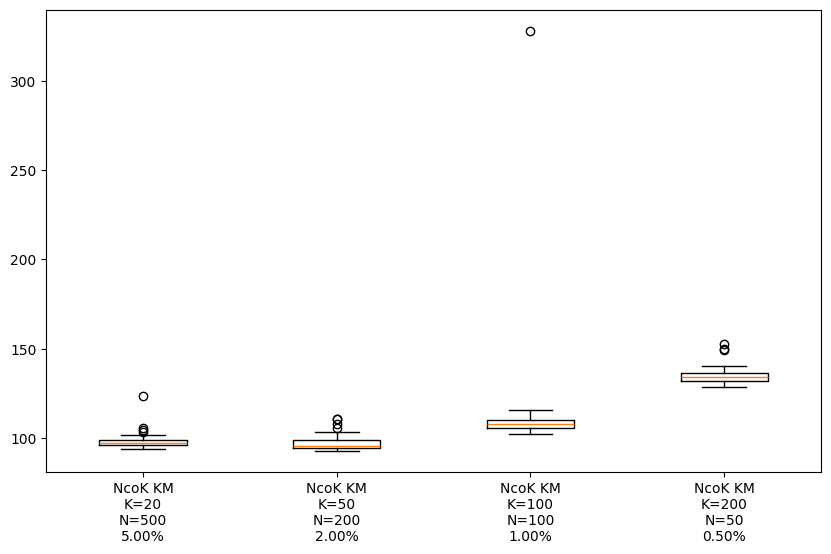

In [27]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(times_NcoK_KM))
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters]);

## $\nu_{1} = 5/2, \nu_{2} = 5/2$

In [5]:
nu_1 = 5/2
nu_2 = 5/2

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [38]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [40]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[1.17084328e-03, 1.57363126e-03, 1.09164121e-03, 2.40763477e-03,
        7.53745439e-04, 2.04182702e-05, 2.28313085e-02, 1.07368602e-03,
        1.99382824e-05],
       [9.16771048e-04, 1.52456315e-03, 6.48216141e-04, 2.14725515e-03,
        8.00603575e-04, 1.15672323e-05, 2.09032452e-02, 9.99047436e-04,
        1.17215411e-05],
       [1.23583996e-03, 1.47269025e-03, 8.08654498e-04, 1.27961311e-03,
        9.45110483e-04, 1.43634281e-05, 2.23534851e-02, 1.08931611e-03,
        1.46834593e-05],
       [8.91201878e-04, 1.52888682e-03, 4.12559799e-04, 1.42231271e-03,
        5.43050973e-04, 1.21122706e-05, 2.36687228e-02, 6.02773404e-04,
        1.18114958e-05],
       [1.43641144e-03, 1.39556496e-03, 6.89968609e-04, 2.39524747e-03,
        8.14449673e-04, 1.97536993e-05, 3.40628268e-02, 9.62172159e-04,
        2.06658941e-05],
       [7.11546530e-04, 1.65376573e-03, 3.92616399e-04, 1.27090776e-03,
        8.15918692e-04, 1.41246189e-05, 1.92694982e-02, 8.26205708e-04,
        1.4

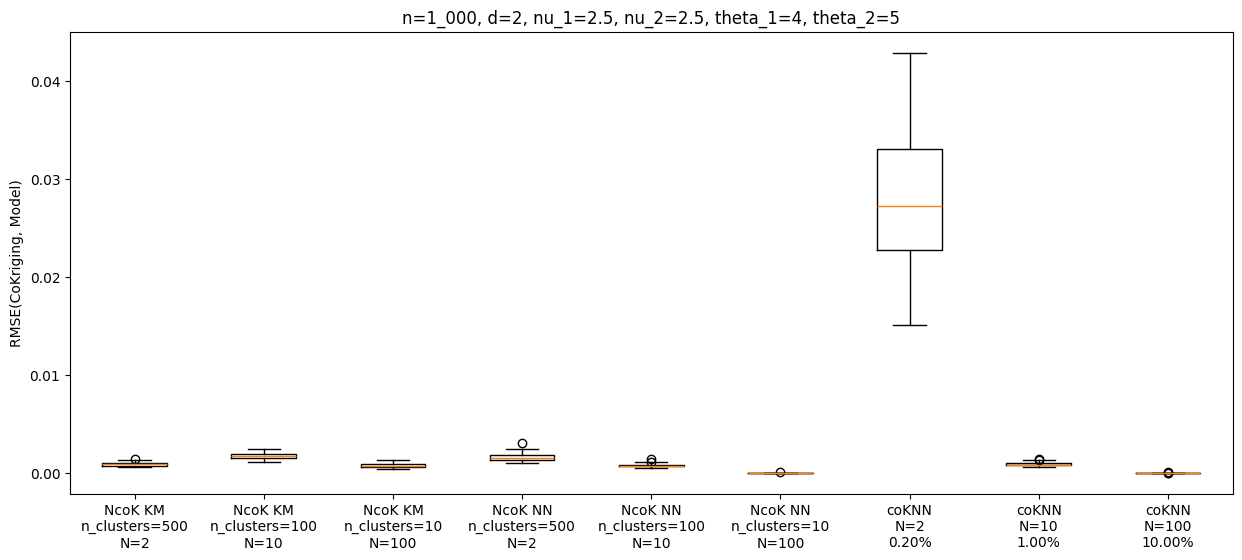

In [41]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [42]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.00103242, 0.00233798, 0.00185821, 0.00189672, 0.00143873,
        0.0010257 , 0.02281668, 0.00164254, 0.0010253 ],
       [0.00109382, 0.00133074, 0.00078783, 0.00210698, 0.00083932,
        0.00060005, 0.02089478, 0.00095577, 0.00060017],
       [0.00148026, 0.00183514, 0.001414  , 0.00188464, 0.00172058,
        0.00113052, 0.0221597 , 0.00172048, 0.00113054],
       [0.00107818, 0.00162282, 0.00064468, 0.00138349, 0.00070519,
        0.00050196, 0.02364982, 0.00072711, 0.000502  ],
       [0.00209968, 0.0019021 , 0.00108138, 0.0028156 , 0.00161131,
        0.0012694 , 0.03383959, 0.00180546, 0.00126914],
       [0.0009452 , 0.00187308, 0.00069826, 0.00150526, 0.00082131,
        0.00070941, 0.01937256, 0.00087934, 0.00070945],
       [0.00128131, 0.00198015, 0.00149412, 0.0014431 , 0.00112828,
        0.00086698, 0.03035019, 0.00128245, 0.00086724],
       [0.00099247, 0.00159105, 0.00095053, 0.00145307, 0.00103743,
        0.00075715, 0.01793881, 0.00112689, 0.00075707],


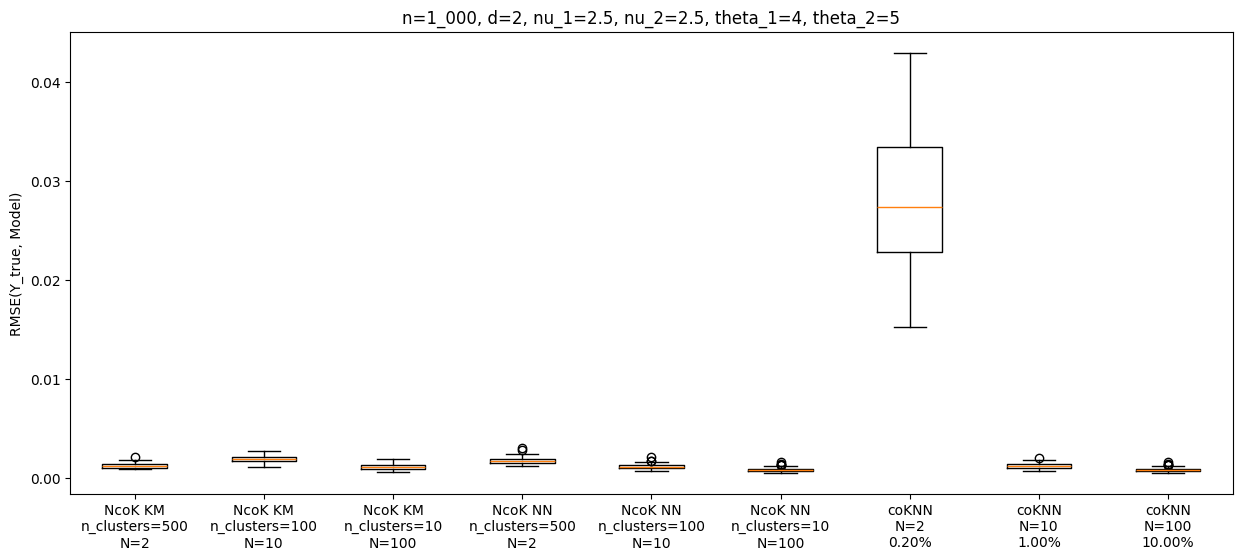

In [43]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [44]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.42328308e+01, 3.06481791e+00, 3.61741161e+00, 1.88334215e+03,
        8.58666627e+01, 9.69932294e+00, 3.13820839e-02, 6.65130615e-02,
        4.83383656e-01],
       [2.41186104e+01, 3.05389547e+00, 4.84972143e+00, 1.90084998e+03,
        8.56003635e+01, 1.02174475e+01, 2.04937458e-02, 7.03084469e-02,
        3.79544735e-01],
       [2.40820138e+01, 3.11657262e+00, 3.48291349e+00, 1.87437390e+03,
        8.69838576e+01, 9.62965894e+00, 3.28803062e-02, 5.46844006e-02,
        3.95000696e-01],
       [2.40840104e+01, 3.14995742e+00, 3.65694094e+00, 1.93824201e+03,
        8.58669782e+01, 9.72536469e+00, 1.68094635e-02, 6.64758682e-02,
        3.83386612e-01],
       [2.40503716e+01, 3.16658497e+00, 3.49969029e+00, 1.87405720e+03,
        8.64506407e+01, 9.60034990e+00, 3.31885815e-02, 4.99863625e-02,
        4.16633606e-01],
       [2.40502629e+01, 3.09993005e+00, 3.61636400e+00, 1.87200723e+03,
        8.70506737e+01, 9.80002332e+00, 3.33945751e-02, 5.82172871e-02,
        3.7

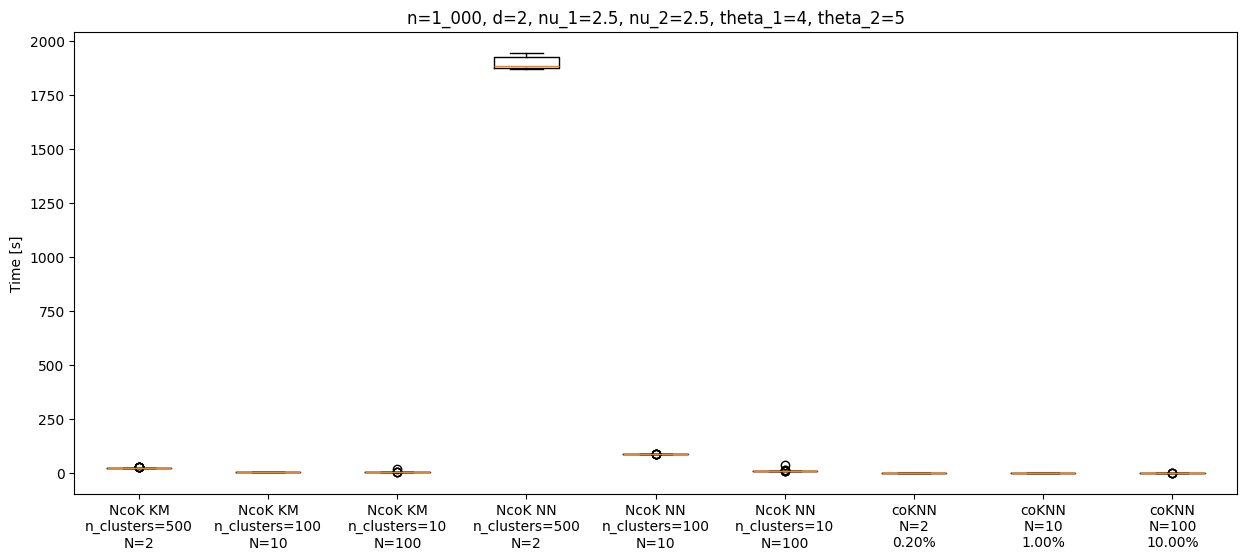

In [45]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Análisis $N$

In [ ]:
ns_clusters = [
    # 10, # 1000
    20, # 500
    50, # 200
    100,# 100
    200,# 50
]

rmses_NcoK_KM = []
rmses_NcoK_KM_true = []
times_NcoK_KM = []

num_replications = 50

for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for n_clusters in ns_clusters:
    # NcoK KM
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux.append(end_time-start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux)
    rmses_NcoK_KM_true.append(rmse_true_aux)
    times_NcoK_KM.append(time_aux)
    
    print(f'{_} listo :)')

In [15]:
np.array(rmses_NcoK_KM)

array([[2.06213741e-05, 3.54241069e-05, 5.45709709e-05, 5.45795429e-05],
       [2.62222890e-05, 3.67597405e-05, 4.15452478e-05, 7.23372926e-05],
       [2.02868245e-05, 5.32403727e-05, 7.10780140e-05, 5.33427651e-05],
       [1.97540877e-05, 3.64927291e-05, 2.56869888e-05, 6.54867646e-05],
       [2.58235165e-05, 3.99313548e-05, 3.87400988e-05, 4.32992186e-05],
       [2.13843618e-05, 6.51335620e-05, 5.41513759e-05, 7.77344702e-05],
       [2.68321950e-05, 4.78592980e-05, 4.36170356e-05, 6.89653010e-05],
       [2.38877135e-05, 2.87852808e-05, 3.76313508e-05, 5.78150685e-05],
       [2.39896519e-05, 3.96440095e-05, 5.56665072e-05, 7.18218197e-05],
       [4.43388473e-05, 5.05655927e-05, 5.99137271e-05, 8.45835781e-05],
       [6.59848748e-05, 3.46230711e-05, 4.73748991e-05, 6.63532738e-05],
       [3.01153737e-05, 2.78973140e-05, 5.43419496e-05, 5.34949433e-05],
       [3.26201804e-05, 2.90757873e-05, 3.66141526e-05, 5.84129446e-05],
       [3.45628771e-05, 4.10424814e-05, 3.88004062e

In [16]:
np.array(rmses_NcoK_KM_true)

array([[4.20166479e-05, 4.64540276e-05, 6.70272342e-05, 6.05204519e-05],
       [4.47767358e-05, 5.40999100e-05, 5.73505000e-05, 9.25215553e-05],
       [4.66177206e-05, 7.95437236e-05, 1.03166909e-04, 6.68785845e-05],
       [3.90774393e-05, 5.40934599e-05, 4.40911642e-05, 7.72609333e-05],
       [4.06095667e-05, 5.16404147e-05, 5.81796290e-05, 5.71294485e-05],
       [3.46518564e-05, 8.49671719e-05, 7.04723878e-05, 9.48480032e-05],
       [3.89305323e-05, 6.02185973e-05, 5.17234449e-05, 7.98931628e-05],
       [5.75830659e-05, 5.99103160e-05, 6.56125595e-05, 7.26145223e-05],
       [4.36351415e-05, 5.11991225e-05, 7.83271988e-05, 9.23481302e-05],
       [6.83671238e-05, 7.66162590e-05, 8.23892959e-05, 8.38242059e-05],
       [7.99269048e-05, 5.06959045e-05, 5.84493202e-05, 7.31827446e-05],
       [5.08808289e-05, 4.22354882e-05, 6.88040356e-05, 6.53547378e-05],
       [4.78782328e-05, 4.44749915e-05, 4.61940667e-05, 5.79676823e-05],
       [4.84370186e-05, 4.77466033e-05, 4.78046332e

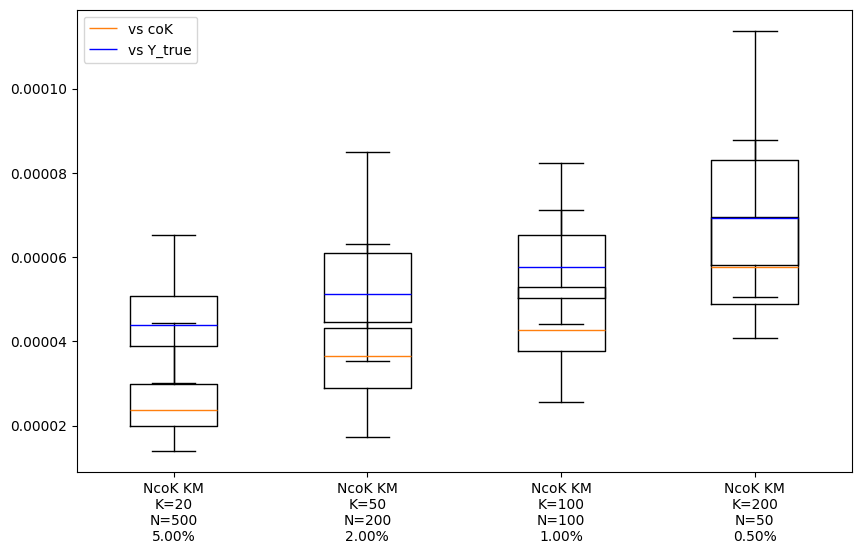

In [21]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(rmses_NcoK_KM), label='vs coK', showfliers=False)
plt.boxplot(np.array(rmses_NcoK_KM_true), medianprops={'c':'b'}, label='vs Y_true', showfliers=False)
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters])
plt.legend();

In [18]:
np.array(times_NcoK_KM)

array([[ 93.59942174,  94.63435173, 109.13495326, 139.50069475],
       [ 92.11881471,  93.85963583, 104.22208524, 135.20395565],
       [ 92.89624095,  96.84952807, 104.22241664, 135.10096741],
       [ 93.20328689,  94.51116753, 104.43387032, 134.42207432],
       [ 95.91414094,  93.63548398, 104.42182779, 134.02898526],
       [118.01605082,  93.38234162, 103.74999905, 134.07141495],
       [ 92.27885866,  93.71329474, 104.49309444, 137.20780182],
       [ 91.95675421,  96.42691684, 105.82925177, 134.8773756 ],
       [ 93.66883445,  98.54834127, 104.90831351, 134.20077705],
       [ 93.55652142,  94.86622047, 105.68030047, 135.78680825],
       [ 96.8081305 ,  96.24941111, 109.15651369, 134.68916941],
       [ 93.16716981,  94.2454133 , 105.16261077, 135.63032365],
       [ 94.05026269,  94.06526589, 104.24781036, 134.83351111],
       [ 93.80191898,  95.55308485, 104.14277101, 135.9886241 ],
       [ 93.51321578,  94.39754939, 105.86153221, 135.9444561 ],
       [ 91.94623423,  93

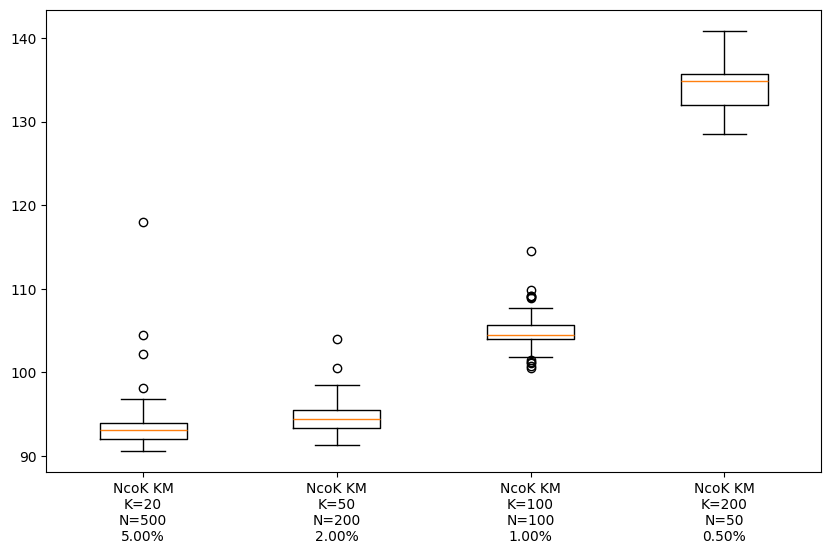

In [19]:
plt.figure(figsize=(10,6))
plt.boxplot(np.array(times_NcoK_KM))
plt.xticks(range(1, 1 + len(ns_clusters)),
           [f'NcoK KM\nK={n_clusters}\nN={n//n_clusters}\n{(n//n_clusters)/n:.2%}' for n_clusters in ns_clusters]);